In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Overview

The expericent was conducted at Fermilab in searching for neutrino oscillations.

The model should be able to classify neutrino particles as:
 - Electron (signal, 1)
 - Muon (background, 0)
 
We will be comparing the out-of-sample (i.e. test set) performance of a Random Forest and a Neural Network classifier.

# Import Data

In [6]:
from pathlib import Path

In [7]:
import miniboone as mb

In [8]:
df = mb.import_data(Path("data/MiniBooNE_PID.txt"))

In [9]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,101.174,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,186.516,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,129.931,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,163.978,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,229.555,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893


In [10]:
# Rename columns
columns_names = mb.get_column_names(df)
df.rename(columns = lambda x : columns_names[x], inplace = True)

In [11]:
df.head()

,PID_1,PID_2,PID_3,PID_4,PID_5,PID_6,PID_7,PID_8,PID_9,PID_10,...,PID_41,PID_42,PID_43,PID_44,PID_45,PID_46,PID_47,PID_48,PID_49,PID_50
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,101.174,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,186.516,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,129.931,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,163.978,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,229.555,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893


In [13]:
# Get the number of elecrons and muons in the file
num_electron, num_muon = mb.get_num_neutrinos(Path("data/MiniBooNE_PID.txt"))

Number of electrons: 36,499
Number of muons: 93,565


In [14]:
# Add the "target" column (1 - electron, 0 - muon)
df = mb.add_target_column(df, num_electron, num_muon)

In [15]:
df.head()

,PID_1,PID_2,PID_3,PID_4,PID_5,PID_6,PID_7,PID_8,PID_9,PID_10,...,PID_42,PID_43,PID_44,PID_45,PID_46,PID_47,PID_48,PID_49,PID_50,target
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130064 entries, 0 to 130063
Data columns (total 51 columns):
PID_1     130064 non-null float64
PID_2     130064 non-null float64
PID_3     130064 non-null float64
PID_4     130064 non-null float64
PID_5     130064 non-null float64
PID_6     130064 non-null float64
PID_7     130064 non-null float64
PID_8     130064 non-null float64
PID_9     130064 non-null float64
PID_10    130064 non-null float64
PID_11    130064 non-null float64
PID_12    130064 non-null float64
PID_13    130064 non-null float64
PID_14    130064 non-null float64
PID_15    130064 non-null float64
PID_16    130064 non-null float64
PID_17    130064 non-null float64
PID_18    130064 non-null float64
PID_19    130064 non-null float64
PID_20    130064 non-null float64
PID_21    130064 non-null float64
PID_22    130064 non-null float64
PID_23    130064 non-null float64
PID_24    130064 non-null float64
PID_25    130064 non-null float64
PID_26    130064 non-null float64
PID_2

In [17]:
mb.pretty_describe(df)

,count,mean,std,min,10%,25%,50%,75%,90%,max
PID_1,"130,064.000",1.252,60.120,-999.000,3.358,4.013,4.788,5.628,6.386,17.057
PID_2,"130,064.000",-2.108,59.913,-999.000,0.489,0.876,1.382,1.948,2.511,8.803
PID_3,"130,064.000",123.795,196.011,-999.000,16.770,49.295,106.136,138.849,196.829,"4,747.670"
PID_4,"130,064.000",-3.313,59.835,-999.000,0.219,0.242,0.272,0.315,0.362,0.737
PID_5,"130,064.000",-3.585,59.818,-999.000,0.000,0.000,0.005,0.013,0.025,0.179
PID_6,"130,064.000",-3.434,59.827,-999.000,0.000,0.085,0.141,0.213,0.348,0.704
PID_7,"130,064.000",-2.628,59.877,-999.000,0.569,0.715,0.923,1.180,1.424,6.241
PID_8,"130,064.000",-2.774,59.867,-999.000,0.735,0.783,0.834,0.874,0.901,0.990
PID_9,"130,064.000",-0.156,60.025,-999.000,3.161,3.285,3.427,3.585,3.755,7.170
PID_10,"130,064.000",-3.421,59.828,-999.000,0.120,0.143,0.171,0.200,0.230,0.525


# Data Pre-Processing

In [18]:
# Train/Test split
tr, te = mb.train_test_stratified_split(df=df,
                                        target='target',
                                        test_size=0.2,
                                        random_state=42)

Training set size: 104,051
Test set size: 26,013


In [19]:
tr.head()

,PID_1,PID_2,PID_3,PID_4,PID_5,PID_6,PID_7,PID_8,PID_9,PID_10,...,PID_42,PID_43,PID_44,PID_45,PID_46,PID_47,PID_48,PID_49,PID_50,target
77123,6.03816,0.896687,49.0690,0.222566,0.010309,0.181529,1.011980,0.740547,3.62303,0.205954,...,-75.4365,-0.311327,15.81250,0.148748,0.312210,-3.319600,4.21003,0.931813,0.176821,0
72151,5.77391,1.829440,134.4870,0.360655,0.004866,0.144070,0.860974,0.837051,3.31444,0.171381,...,-48.1724,1.030540,7.63095,0.000000,0.236221,-0.383334,2.85120,1.089330,0.199093,0
114434,4.75171,2.855140,30.2524,0.303063,0.000000,0.016430,0.775962,0.697463,3.17908,0.160415,...,-16.3072,0.850044,2.81757,0.000000,0.155105,0.446280,8.88321,1.766660,0.362892,0
51797,5.65324,1.330120,98.4080,0.331628,0.000000,0.154544,0.767144,0.861814,3.24334,0.200865,...,-18.8086,0.780023,5.12805,0.000000,0.159206,0.129452,3.43628,1.861810,0.156294,0
18964,6.27460,0.590436,317.9210,0.206096,0.065554,0.147159,1.364270,0.858800,3.94942,0.125982,...,-114.1540,-0.703854,35.66360,0.151371,0.345276,-4.801410,1.04013,0.346961,0.135878,1


In [20]:
te.head()

,PID_1,PID_2,PID_3,PID_4,PID_5,PID_6,PID_7,PID_8,PID_9,PID_10,...,PID_42,PID_43,PID_44,PID_45,PID_46,PID_47,PID_48,PID_49,PID_50,target
41280,6.10449,3.01404,54.744,0.268960,0.000000,0.209840,0.441349,0.733103,3.77155,0.129145,...,-27.56700,0.926436,9.30181,0.009709,0.378249,-0.603040,5.22581,5.22207,0.276978,0
87120,5.76793,2.49336,127.411,0.295135,0.023981,0.052872,0.652366,0.716619,3.85440,0.167363,...,-46.34790,0.019669,16.63530,0.019185,0.200576,-0.900994,3.77733,3.09090,0.261782,0
123782,4.28501,1.04153,130.159,0.259182,0.011869,0.126784,0.766086,0.792867,3.31075,0.200812,...,3.51812,-0.024209,3.89646,0.000000,0.105930,0.305190,2.21422,1.33556,0.282210,0
111553,5.42269,2.03177,119.095,0.385580,0.000000,0.175917,0.671952,0.838499,3.36618,0.141043,...,-40.48060,2.239810,7.99695,0.000000,0.204154,-0.212361,2.02491,3.21310,0.276577,0
36728,7.50649,2.67148,60.956,0.312372,0.016026,0.098686,1.328770,0.737576,3.94554,0.277984,...,-20.70410,2.357960,11.88500,0.131410,0.482940,-6.175320,2.20068,2.51897,0.133771,0


In [21]:
# X/y split of training set
tr_X, tr_y = mb.x_y_split(df=tr,
                          y_col='target')

Class ratio: 0.28062


In [22]:
# X/y split of test set
te_X, te_y = mb.x_y_split(df=te,
                          y_col='target')

Class ratio: 0.28063


## *PCA*

We want to create another set of training and test data, with reduced dimensionality. We will test if this reduced dimensionality will improve our model results/runtime.

In [23]:
from sklearn.decomposition import PCA

PCA relies on variables being in the same scale. For standardization, we will be using RobustScaler, since it's less sensitive to outliers.

We will use PyOD to identify outliers. Specifically, we will use the k-Nearest Neighbour detector. [Source code](https://github.com/yzhao062/pyod/blob/master/pyod/models/knn.py)

In [24]:
tr_X_removed_outliers, tr_y_removed_outliers = mb.remove_outliers_knn(x=tr_X,
                                                                      y=tr_y,
                                                                      contamination=0.05)

5.00% among 104,051 sample points are identified and removed as outliers


In [25]:
mb.pretty_describe(tr_X_removed_outliers)

,count,mean,std,min,10%,25%,50%,75%,90%,max
PID_1,"98,848.000",1.053,61.972,-999.000,3.409,4.062,4.816,5.646,6.392,17.057
PID_2,"98,848.000",-2.283,61.760,-999.000,0.576,0.947,1.427,1.981,2.538,8.606
PID_3,"98,848.000",104.047,120.060,-999.000,16.222,47.204,103.797,135.202,170.475,"1,587.080"
PID_4,"98,848.000",-3.538,61.677,-999.000,0.219,0.242,0.273,0.316,0.362,0.713
PID_5,"98,848.000",-3.812,61.660,-999.000,0.000,0.000,0.005,0.012,0.023,0.179
PID_6,"98,848.000",-3.659,61.669,-999.000,0.000,0.089,0.142,0.213,0.350,0.704
PID_7,"98,848.000",-2.860,61.720,-999.000,0.564,0.708,0.915,1.174,1.423,5.979
PID_8,"98,848.000",-3.002,61.710,-999.000,0.734,0.781,0.831,0.871,0.897,0.967
PID_9,"98,848.000",-0.377,61.873,-999.000,3.171,3.290,3.430,3.587,3.755,7.170
PID_10,"98,848.000",-3.647,61.670,-999.000,0.120,0.143,0.171,0.201,0.231,0.525


In [26]:
from sklearn.pipeline import Pipeline

In [27]:
from sklearn.preprocessing import RobustScaler

In [28]:
pca_pipeline = Pipeline(
    [('standardize', RobustScaler(quantile_range = (0.1, 0.9))),
     ('pca', PCA(n_components=0.99, random_state=42))]
)

In [29]:
tr_X_pca = pca_pipeline.fit_transform(tr_X_removed_outliers)
tr_y_pca = tr_y_removed_outliers.values

In [30]:
np.sum(pca_pipeline.named_steps['pca'].explained_variance_ratio_)

0.993043005520252

In [31]:
tr_X_pca.shape

(98848, 6)

In [32]:
column_names_pca = ["z{0}".format(i+1) for i in range(tr_X_pca.shape[1])]
print(column_names_pca)

['z1', 'z2', 'z3', 'z4', 'z5', 'z6']


In [33]:
tr_pca = pd.DataFrame(tr_X_pca, columns=column_names_pca)

In [34]:
tr_pca['y'] = tr_y_pca

In [36]:
mb.pretty_describe(tr_pca)

,count,mean,std,min,10%,25%,50%,75%,90%,max
z1,"98,848.000",-0.000,0.483,-2.378,-0.344,-0.091,0.054,0.143,0.201,6.399
z2,"98,848.000",0.000,0.379,-0.461,-0.260,-0.201,-0.106,0.061,0.362,3.474
z3,"98,848.000",0.000,0.142,-0.494,-0.198,-0.095,0.014,0.106,0.174,0.535
z4,"98,848.000",-0.000,0.095,-0.175,-0.101,-0.059,-0.005,0.041,0.086,1.325
z5,"98,848.000",0.000,0.061,-0.276,-0.084,-0.048,0.009,0.042,0.071,0.280
z6,"98,848.000",-0.000,0.043,-0.194,-0.051,-0.028,-0.002,0.026,0.053,0.291
y,"98,848.000",0.258,0.438,0.000,0.000,0.000,0.000,1.000,1.000,1.000


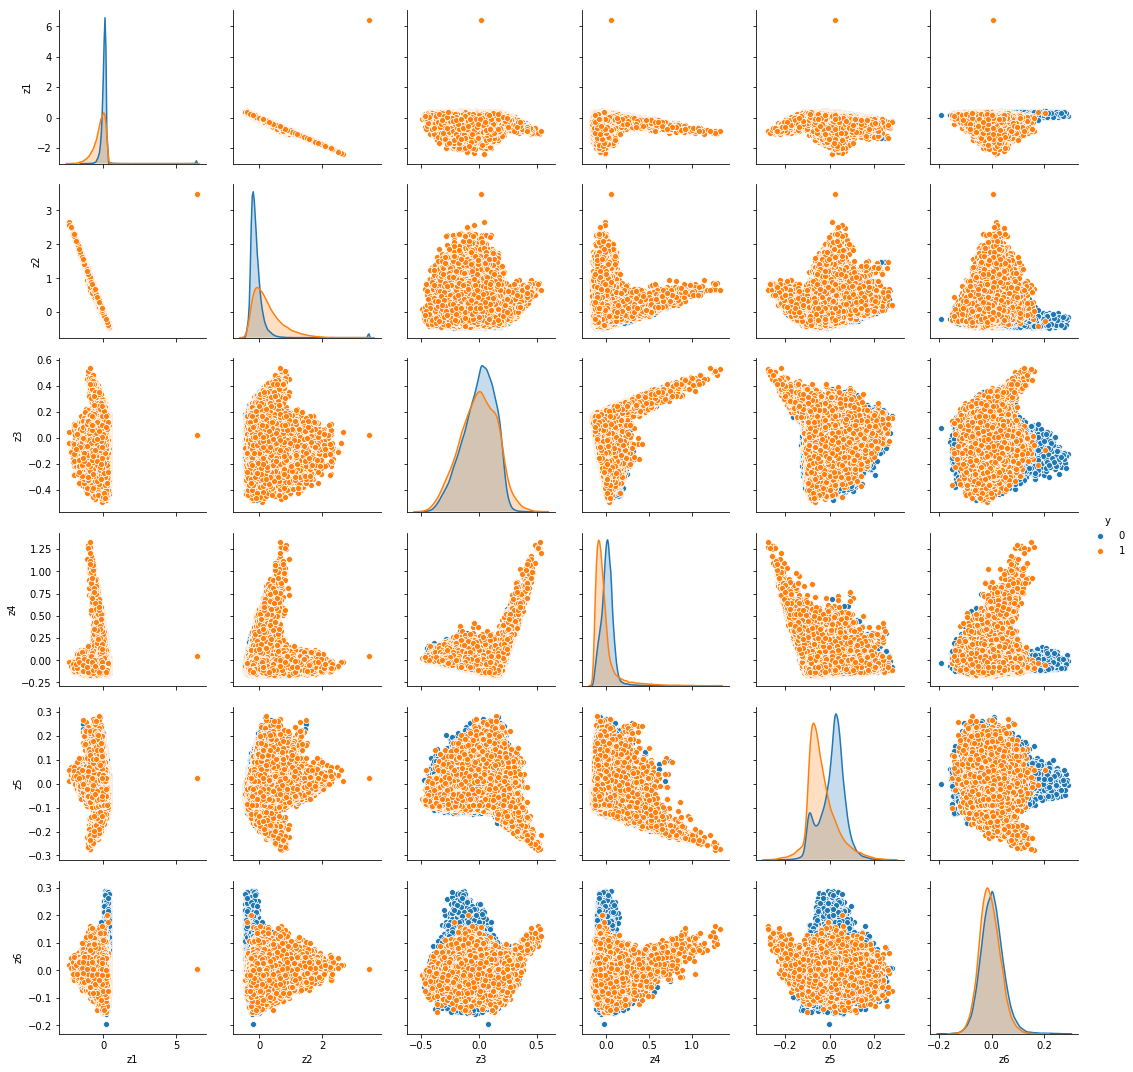

In [37]:
sns.pairplot(tr_pca, vars=column_names_pca, hue='y')

In [38]:
te_X_pca = pca_pipeline.transform(te_X)
te_y_pca = te_y.values

In [39]:
te_X_pca.shape

(26013, 6)

In [40]:
te_y_pca.shape

(26013,)

# Trees

First, We will tune and train a Random Forest Classifier model using the PCA-reduced training set. We will compare the results against a Neutral Network model.

In [41]:
tr_y_pca.sum() / len(tr_y_pca)

0.2580831175137585

Since the class ratio is not too imblanced (~25%), we will use AUC-ROC score as the key performace metric

In [42]:
import time

In [43]:
import itertools
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

## *Preliminary Tuning using Single Decision Tree*

## *1. max_depth*

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    5.1s finished


The best parameters: {'max_depth': 8}
The best score: 0.9202809753613037


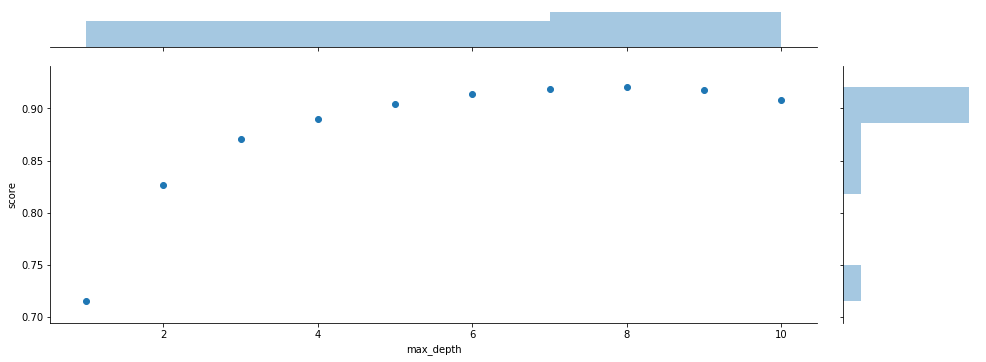

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=2)

In [44]:
mb.evaluate_params(estimator=DecisionTreeClassifier(),
                   cv_method='grid',
                   param_grid={'max_depth' : [i+1 for i in range(10)]},
                   x=tr_X_pca,
                   y=tr_y_pca)

## *2. min_samples_split*

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   11.2s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   44.3s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:  1.2min finished


The best parameters: {'min_samples_split': 0.007475373737373737}
The best score: 0.9270648368938202


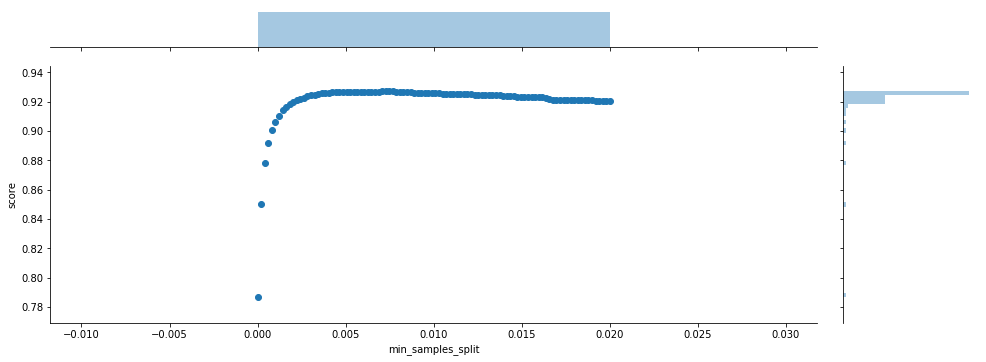

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'min_samples_split': array([1.0000e-06, 2.0301e-04, ..., 1.9798e-02, 2.0000e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=2)

In [46]:
mb.evaluate_params(estimator=DecisionTreeClassifier(),
                   cv_method='grid',
                   param_grid={'min_samples_split' : np.linspace(0.000001, 0.02, 100)},
                   x=tr_X_pca,
                   y=tr_y_pca)

## *3. min_samples_leaf*

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   25.7s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:   45.0s finished


The best parameters: {'min_samples_leaf': 0.001617080808080808}
The best score: 0.930138673059281


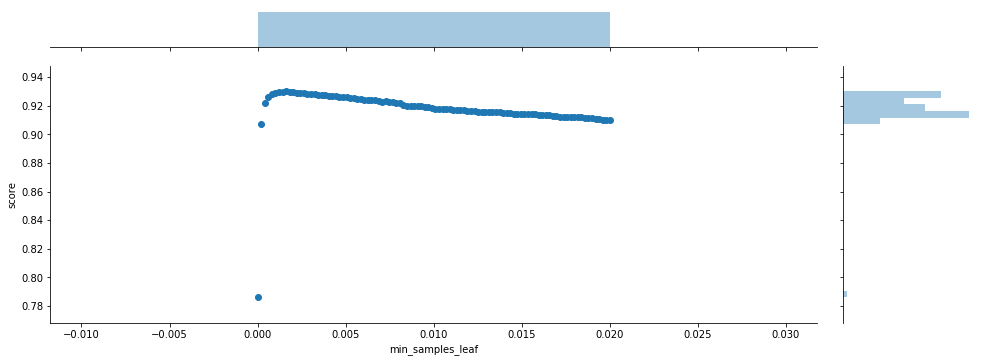

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'min_samples_leaf': array([1.0000e-06, 2.0301e-04, ..., 1.9798e-02, 2.0000e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=2)

In [47]:
mb.evaluate_params(estimator=DecisionTreeClassifier(),
                   cv_method='grid',
                   param_grid={'min_samples_leaf' : np.linspace(0.000001, 0.02, 100)},
                   x=tr_X_pca,
                   y=tr_y_pca)

## *4. max_leaf_nodes*

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    4.3s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:   19.2s finished


The best parameters: {'max_leaf_nodes': 252}
The best score: 0.9250357248791274


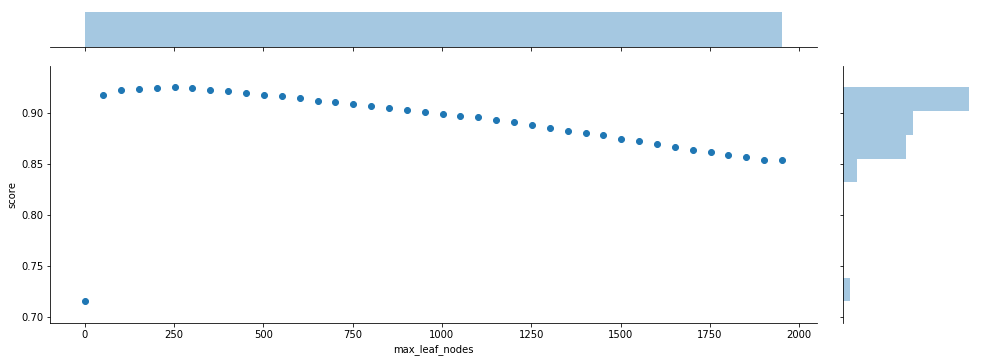

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'max_leaf_nodes': [2, 52, 102, 152, 202, 252, 302, 352, 402, 452, 502, 552, 602, 652, 702, 752, 802, 852, 902, 952, 1002, 1052, 1102, 1152, 1202, 1252, 1302, 1352, 1402, 1452, 1502, 1552, 1602, 1652, 1702, 1752, 1802, 1852, 1902, 1952]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=2)

In [48]:
mb.evaluate_params(estimator=DecisionTreeClassifier(),
                   cv_method='grid',
                   param_grid={'max_leaf_nodes' : [i for i in range(2, 2000, 50)]},
                   x=tr_X_pca,
                   y=tr_y_pca)

Conclusion:
1. `max_depth`: best is around **6-8**
2. `min_sample_split`: best is around **0.008** (or about ~800 samples) 
3. `min_sample_leaf`: best is around **0.0016** (or about ~160 samples)
4. `max_leaf_nodes`: best is around **250**

## *Random Forest Classifier - PCA Reduced*

In [49]:
rfc = RandomForestClassifier()

In [69]:
param_grid_rfc = {'n_estimators' : stats.randint(600, 1000),
                  'max_depth' : [i for i in range(6, 9)],
                  'min_samples_split' : stats.uniform(0.005, 0.011),
                  'min_samples_leaf' : stats.uniform(0.0001, 0.005),
                  'max_leaf_nodes' : stats.randint(200, 300),
                  'max_features' : stats.randint(3, tr_X_pca.shape[1] + 1)}

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 26.8min
[Parallel(n_jobs=6)]: Done  75 out of  75 | elapsed: 64.7min finished


The best parameters: {'max_depth': 8, 'max_features': 4, 'max_leaf_nodes': 277, 'min_samples_leaf': 0.003433122750820358, 'min_samples_split': 0.006164993335624952, 'n_estimators': 822}
The best score: 0.9334356067607446


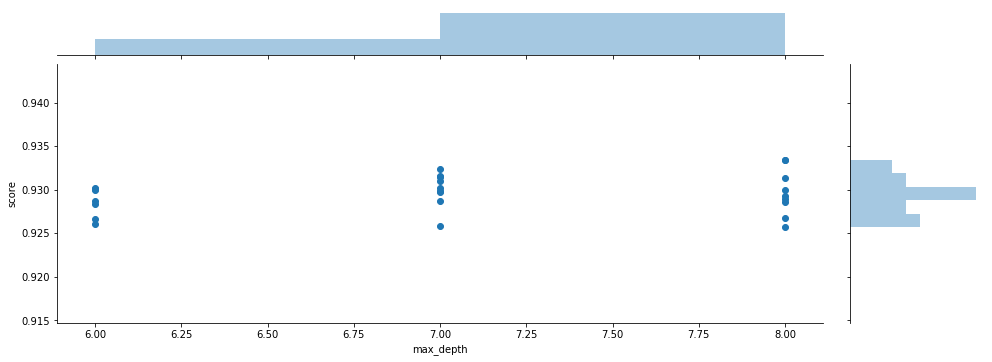

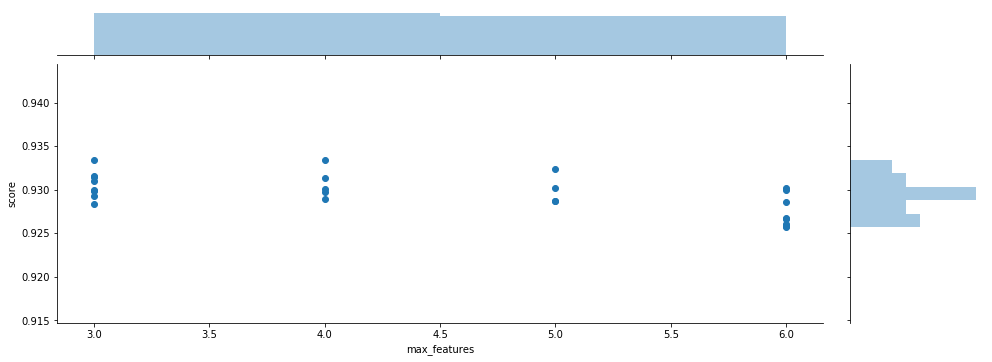

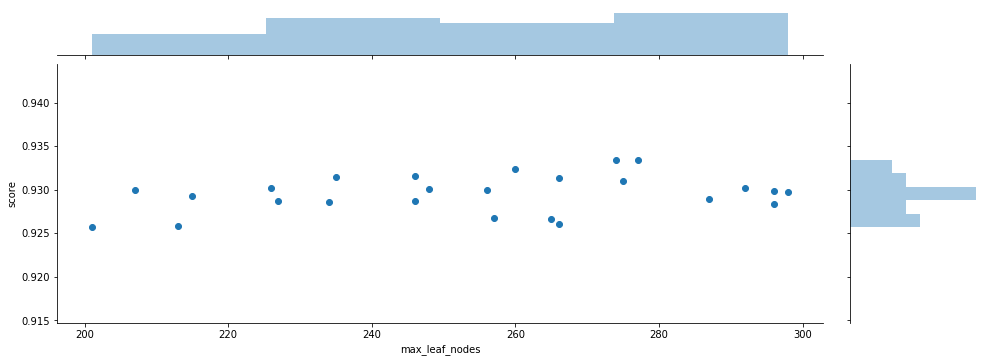

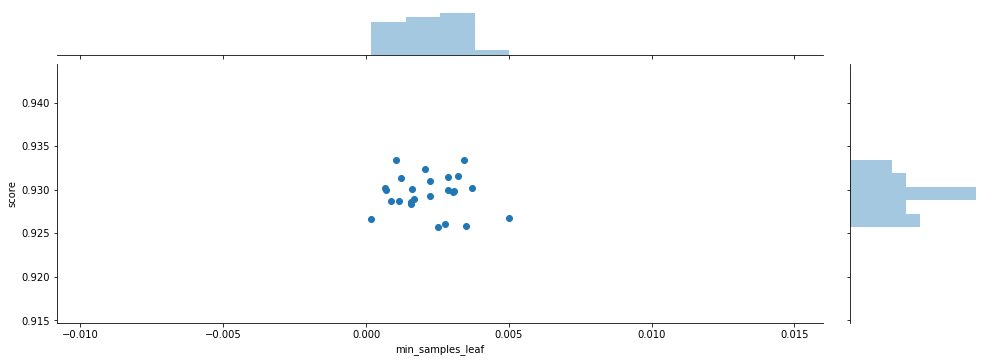

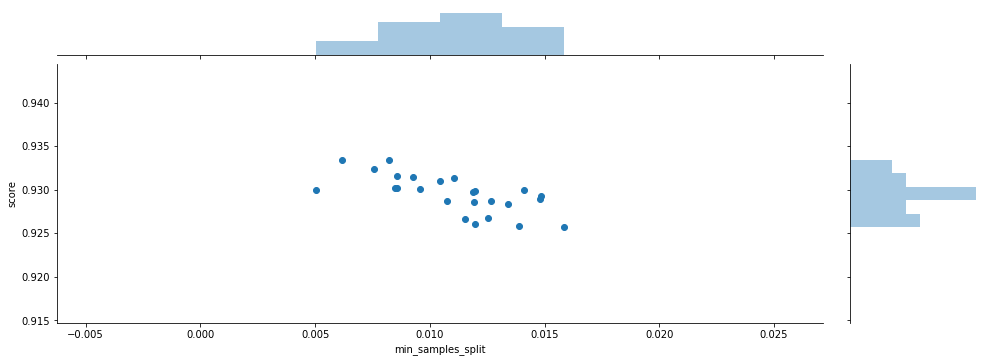

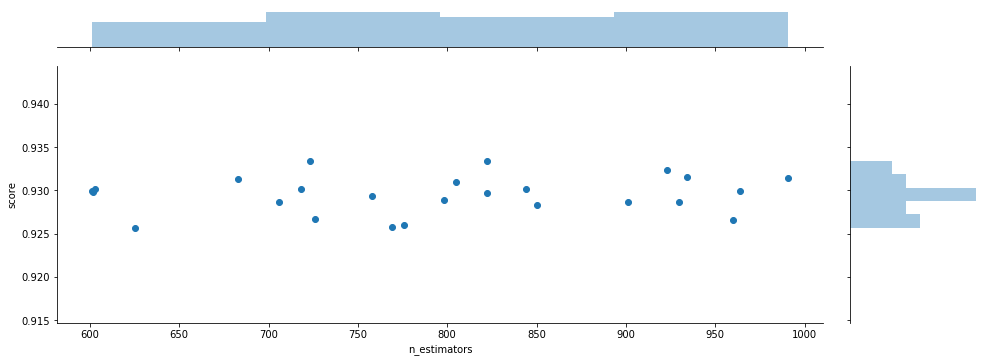

In [70]:
rfc_grid = mb.evaluate_params(estimator=rfc,
                              cv_method='randomized',
                              param_grid=param_grid_rfc,
                              x=tr_X_pca,
                              y=tr_y_pca,
                              cv=3,
                              scoring='roc_auc',
                              n_iter=25,
                              verbose=2,
                              n_jobs=6,
                              random_state=123)

## Random Forest Classifier - Final

In [50]:
# Using the best parameters
rfc_final = RandomForestClassifier(n_estimators = 800,
                                   criterion = 'gini',
                                   max_depth = 8,
                                   max_features = 4,
                                   max_leaf_nodes = 300,
                                   min_samples_leaf = 0.0035,
                                   min_samples_split = 0.006,
                                   verbose = False,
                                   random_state = 42,
                                   n_jobs = -1)

In [51]:
# Fit the training set
rfc_final.fit(tr_X_pca, tr_y_pca)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=4, max_leaf_nodes=300,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.0035, min_samples_split=0.006,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
            oob_score=False, random_state=42, verbose=False,
            warm_start=False)

In [52]:
# Predict on training set
tr_y_pred_rfc = rfc_final.predict(tr_X_pca)
tr_y_prob_rfc = rfc_final.predict_proba(tr_X_pca)

In [53]:
# Predict on test set
te_y_pred_rfc = rfc_final.predict(te_X_pca)
te_y_prob_rfc = rfc_final.predict_proba(te_X_pca)

In [54]:
# ROC AUC Scores
print('ROC AUC - Train')
print(roc_auc_score(tr_y_removed_outliers, tr_y_prob_rfc[:,1]))
print('ROC AUC - Test')
print(roc_auc_score(te_y, te_y_prob_rfc[:,1]))

ROC AUC - Train
0.9364032279461927
ROC AUC - Test
0.9350916072556694


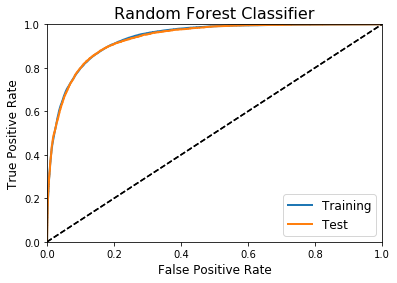

In [55]:
# ROC AUC curves
fpr_rfc_tr, tpr_rfc_tr, _ = roc_curve(tr_y_removed_outliers, tr_y_prob_rfc[:,1])
fpr_rfc_te, tpr_rfc_te, _ = roc_curve(te_y, te_y_prob_rfc[:,1])

mb.plot_roc_curve(fpr_rfc_tr, tpr_rfc_tr, "Training")
mb.plot_roc_curve(fpr_rfc_te, tpr_rfc_te, "Test")

plt.title('Random Forest Classifier', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.show()

The model is doing really well, with no over/under fitting.

# Neural Network Classifier

In [56]:
from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.


We will build a NN with 1 input layer + 2 hidden layers + 1 output layer
- Input layer (PCA-reduced)
- ReLU (4 nodes)
- ReLU (4 nodes)
- Output layer (Sigmoid)

In [57]:
nnc = Sequential()

In [58]:
# First layer
nnc.add(Dense(4, activation='relu', kernel_initializer='random_normal'))

In [59]:
# Second layer
nnc.add(Dense(4, activation='relu', kernel_initializer='random_normal'))

In [60]:
# Output layer
nnc.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [61]:
# Compile the neural network
nnc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [62]:
# Fitting the data
nnc.fit(tr_X_pca, tr_y_pca, batch_size=1000, epochs=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
98848/98848 [==============================] - 2s 18us/step - loss: 0.6814 - acc: 0.7370
Epoch 2/100
98848/98848 [==============================] - 1s 9us/step - loss: 0.6535 - acc: 0.7818
Epoch 3/100
98848/98848 [==============================] - 1s 11us/step - loss: 0.6132 - acc: 0.8289
Epoch 4/100
98848/98848 [==============================] - 1s 11us/step - loss: 0.5777 - acc: 0.8310
Epoch 5/100
98848/98848 [==============================] - 1s 11us/step - loss: 0.5529 - acc: 0.8330
Epoch 6/100
98848/98848 [==============================] - 1s 12us/step - loss: 0.5327 - acc: 0.8355
Epoch 7/100
98848/98848 [==============================] - 1s 12us/step - loss: 0.5141 - acc: 0.8396
Epoch 8/100
98848/98848 [==============================] - 1s 12us/step - loss: 0.4952 - acc: 0.8469
Epoch 9/100
98848/98848 [==============================] - 2s 16us/step - loss: 0.4767 - acc: 0.8539
Epoch 10/100
98848/98848 [==================

98848/98848 [==============================] - 1s 9us/step - loss: 0.2864 - acc: 0.8797
Epoch 79/100
98848/98848 [==============================] - 1s 7us/step - loss: 0.2862 - acc: 0.8799
Epoch 80/100
98848/98848 [==============================] - 1s 5us/step - loss: 0.2861 - acc: 0.8798
Epoch 81/100
98848/98848 [==============================] - 1s 6us/step - loss: 0.2859 - acc: 0.8796
Epoch 82/100
98848/98848 [==============================] - 1s 8us/step - loss: 0.2858 - acc: 0.8798
Epoch 83/100
98848/98848 [==============================] - 1s 12us/step - loss: 0.2857 - acc: 0.8798
Epoch 84/100
98848/98848 [==============================] - 1s 8us/step - loss: 0.2856 - acc: 0.8798
Epoch 85/100
98848/98848 [==============================] - 1s 5us/step - loss: 0.2855 - acc: 0.8799
Epoch 86/100
98848/98848 [==============================] - 1s 5us/step - loss: 0.2854 - acc: 0.8799
Epoch 87/100
98848/98848 [==============================] - 1s 8us/step - loss: 0.2853 - acc: 0.8800
Ep

In [63]:
# Evaluate the model on the training set
nnc.evaluate(tr_X_pca, tr_y_pca)

98848/98848 [==============================] - 5s 55us/step


[0.28425342013999727, 0.8795119779864033]

In [64]:
print(confusion_matrix(te_y_pca, nnc.predict(te_X_pca) > 0.5))

[[17539  1174]
 [ 2039  5261]]


In [65]:
# Predict on training set
tr_y_pred_nnc = nnc.predict(tr_X_pca)
tr_y_prob_nnc = nnc.predict_proba(tr_X_pca)

In [66]:
# Predict on test set
te_y_pred_nnc = nnc.predict(te_X_pca)
te_y_prob_nnc = nnc.predict_proba(te_X_pca)

In [67]:
# ROC AUC Scores
print('ROC AUC - Train')
print(roc_auc_score(tr_y_removed_outliers, tr_y_prob_nnc))
print('ROC AUC - Test')
print(roc_auc_score(te_y, te_y_prob_nnc))

ROC AUC - Train
0.9336741524022933
ROC AUC - Test
0.9344510738633826


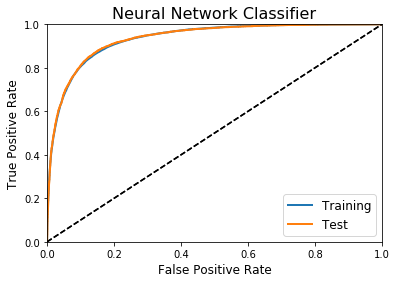

In [68]:
# ROC AUC curves
fpr_nnc_tr, tpr_nnc_tr, _ = roc_curve(tr_y_removed_outliers, tr_y_prob_nnc)
fpr_nnc_te, tpr_nnc_te, _ = roc_curve(te_y, te_y_prob_nnc)

mb.plot_roc_curve(fpr_nnc_tr, tpr_nnc_tr, "Training")
mb.plot_roc_curve(fpr_nnc_te, tpr_nnc_te, "Test")

plt.title('Neural Network Classifier', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.show()

The Neural Network Classifier also does extremely well, without any over/under fitting

# Conclusion

Both the Random Forest Classifier and the Neural Network Classifier are able to achieve high accuracy scores. However, RFC is slightly better with a slightly higher AUC score, and NNC is slightly better in terms of model running time.